# Load Libraries

In [1]:
import numpy as np
import pandas as pd
from glob import glob
import os
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from pathlib import Path
import plotly.express as px

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Set Path

In [2]:
data_dir = Path("../input/google-smartphone-decimeter-challenge")

# Load Data

In [3]:
df_train = pd.read_pickle(str(data_dir / "gsdc_cleaned_train.pkl.gzip"))

In [4]:
df_test = pd.read_pickle(str(data_dir / "gsdc_cleaned_test.pkl.gzip"))

In [5]:
set(df_train.columns.unique()) - set(df_test.columns.unique())

{'courseDegree',
 'hDop',
 'speedMps',
 't_heightAboveWgs84EllipsoidM',
 't_latDeg',
 't_lngDeg',
 'timeSinceFirstFixSeconds',
 'vDop'}

In [6]:
for col in df_train.columns:
    print(col)

collectionName
phoneName
millisSinceGpsEpoch
latDeg
lngDeg
heightAboveWgs84EllipsoidM
phone
timeSinceFirstFixSeconds
hDop
vDop
speedMps
courseDegree
t_latDeg
t_lngDeg
t_heightAboveWgs84EllipsoidM
constellationType
svid
signalType
receivedSvTimeInGpsNanos
xSatPosM
ySatPosM
zSatPosM
xSatVelMps
ySatVelMps
zSatVelMps
satClkBiasM
satClkDriftMps
rawPrM
rawPrUncM
isrbM
ionoDelayM
tropoDelayM
utcTimeMillis
elapsedRealtimeNanos
yawDeg
rollDeg
pitchDeg
utcTimeMillis_Status
SignalCount
SignalIndex
ConstellationType
Svid
CarrierFrequencyHz
Cn0DbHz
AzimuthDegrees
ElevationDegrees
UsedInFix
HasAlmanacData
HasEphemerisData
BasebandCn0DbHz
utcTimeMillis_UncalMag
elapsedRealtimeNanos_UncalMag
UncalMagXMicroT
UncalMagYMicroT
UncalMagZMicroT
BiasXMicroT
BiasYMicroT
BiasZMicroT
utcTimeMillis_UncalAccel
elapsedRealtimeNanos_UncalAccel
UncalAccelXMps2
UncalAccelYMps2
UncalAccelZMps2
BiasXMps2
BiasYMps2
BiasZMps2
utcTimeMillis_UncalGyro
elapsedRealtimeNanos_UncalGyro
UncalGyroXRadPerSec
UncalGyroYRadPerSec
U

# Data Analysis

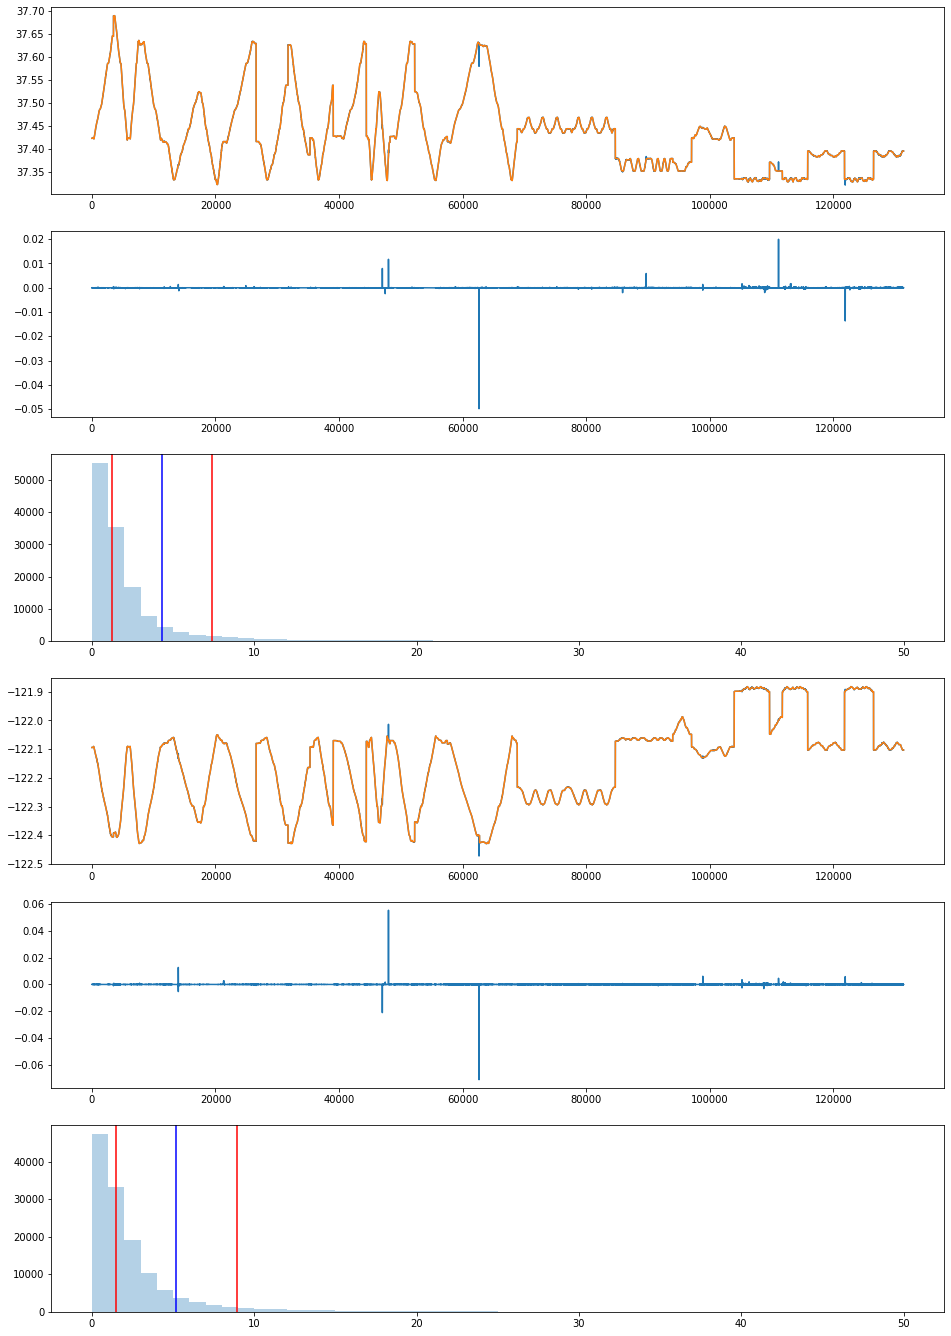

In [7]:
latPosErr = 6_367_000 * np.deg2rad(abs(df_train['latDeg'] - df_train['t_latDeg']))
lngPosErr = 6_367_000 *  np.deg2rad(abs(df_train['lngDeg'] - df_train['t_lngDeg']))

plt.figure(figsize = (16, 24))
plt.subplot(6,1,1)
plt.plot(df_train['latDeg'])
plt.plot(df_train['t_latDeg'])

plt.subplot(6,1,2)
plt.plot(df_train['latDeg'] - df_train['t_latDeg'])

plt.subplot(6,1,3)
plt.hist(latPosErr, bins = np.arange(0, 50 + 1, 1), alpha = 1/3)
plt.axvline(latPosErr.quantile(0.5), color = 'r')
plt.axvline(latPosErr.quantile(0.95), color = 'r')
plt.axvline((latPosErr.quantile(0.5) + latPosErr.quantile(0.95))/2, color = 'b')

plt.subplot(6,1,4)
plt.plot(df_train['lngDeg'])
plt.plot(df_train['t_lngDeg'])

plt.subplot(6,1,5)
plt.plot(df_train['lngDeg'] - df_train['t_lngDeg'])

plt.subplot(6,1,6)
plt.hist(lngPosErr, bins = np.arange(0, 50 + 1, 1), alpha = 1/3)
plt.axvline(lngPosErr.quantile(0.5), color = 'r')
plt.axvline(lngPosErr.quantile(0.95), color = 'r')
plt.axvline((lngPosErr.quantile(0.5) + lngPosErr.quantile(0.95))/2, color = 'b')

plt.show()

D:\Sangwons_Room\00_SoftWares\Anaconda\envs\torch\lib\site-packages\ipykernel_launcher.py:4: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



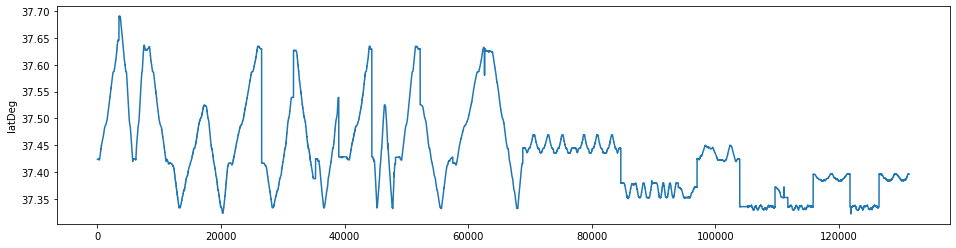

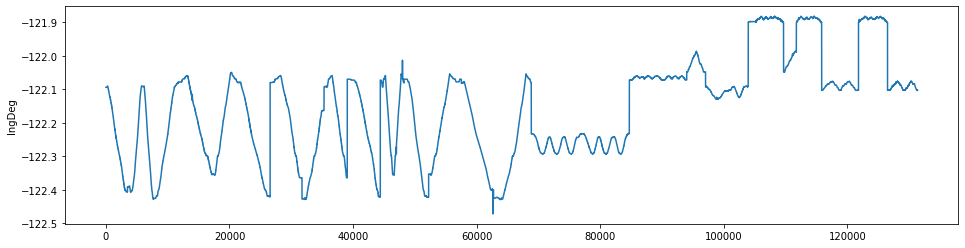

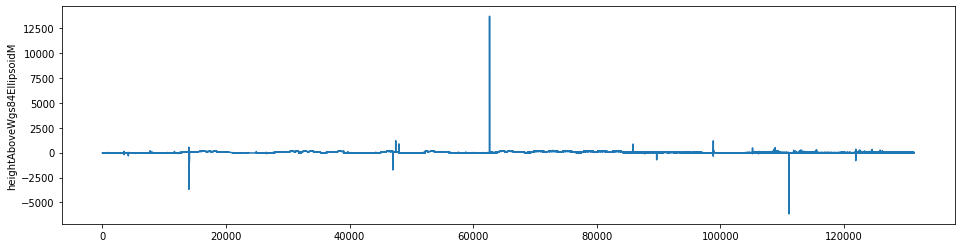

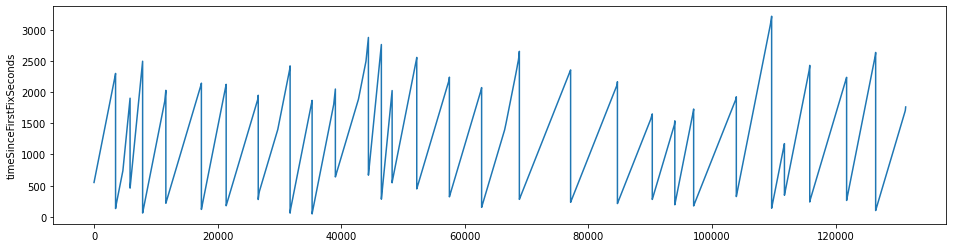

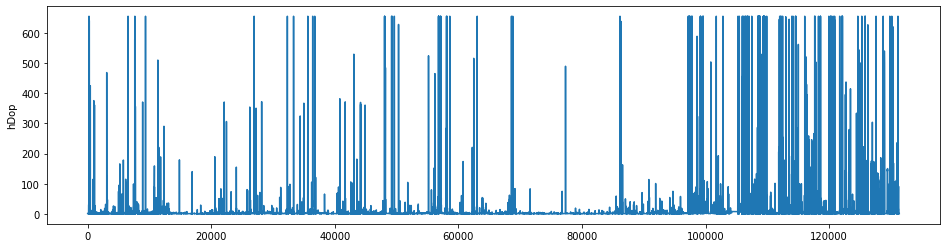

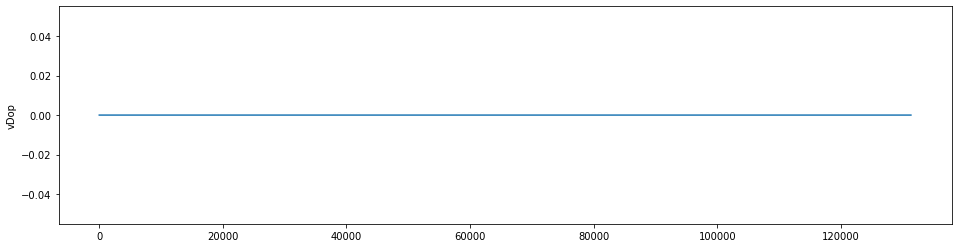

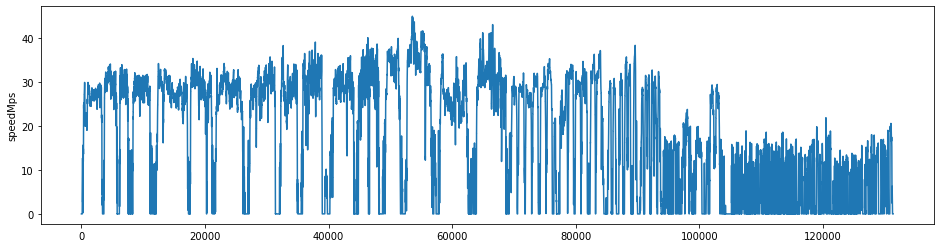

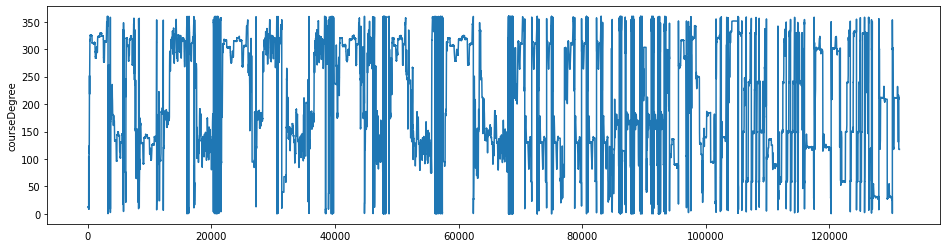

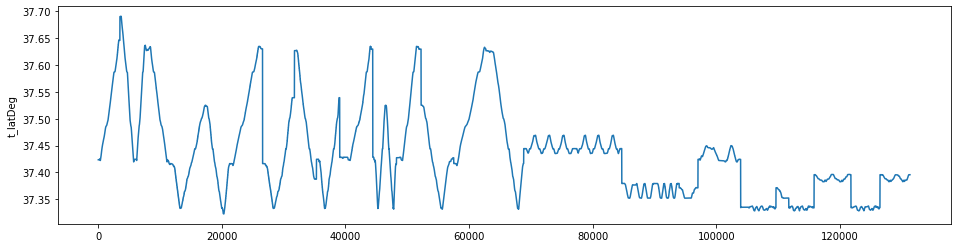

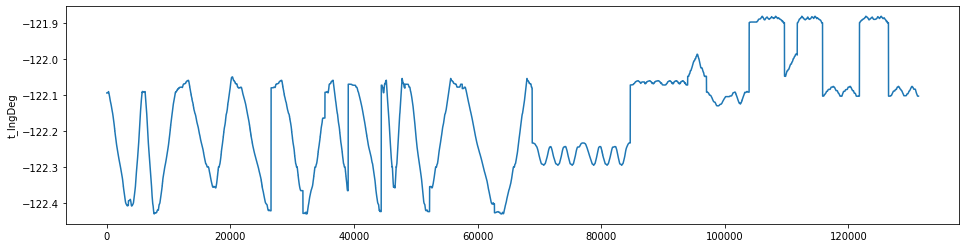

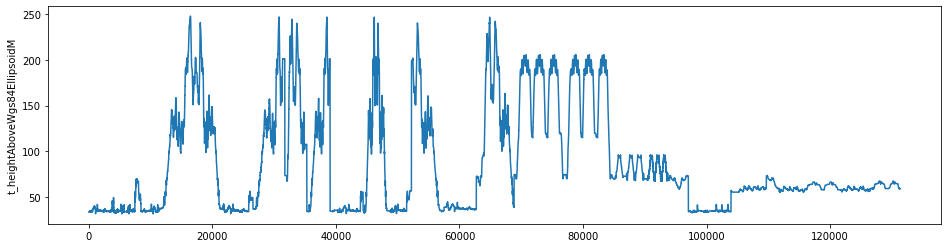

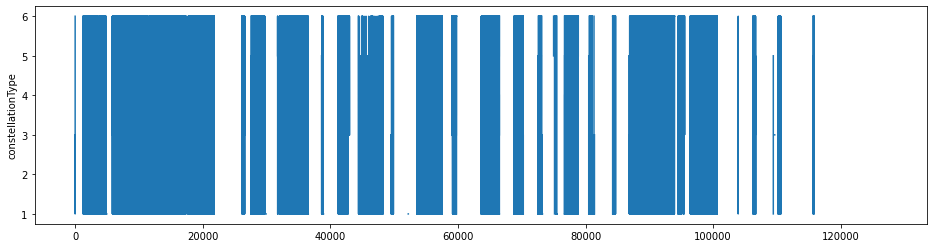

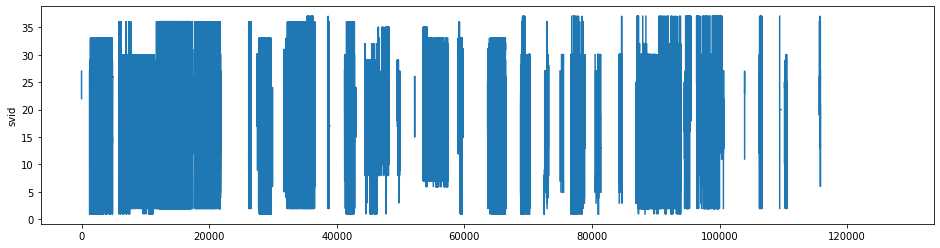

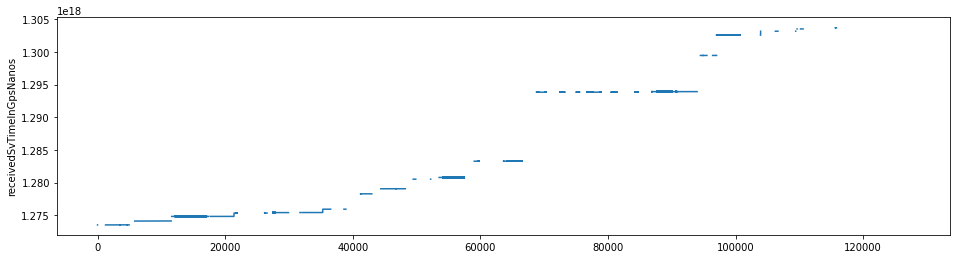

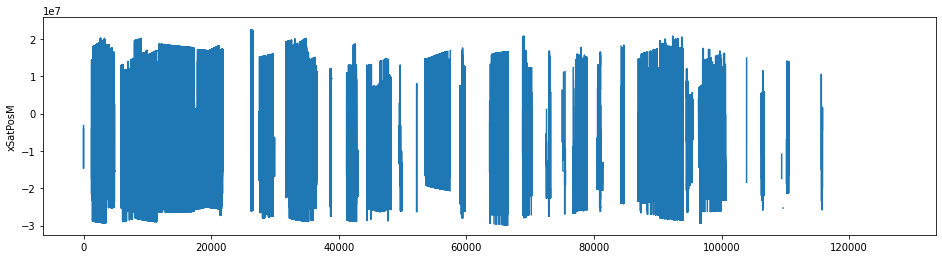

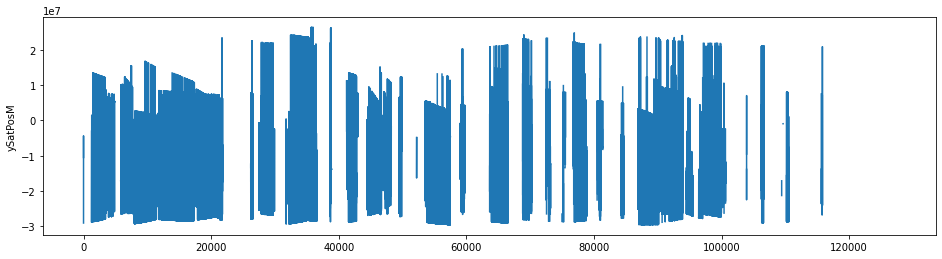

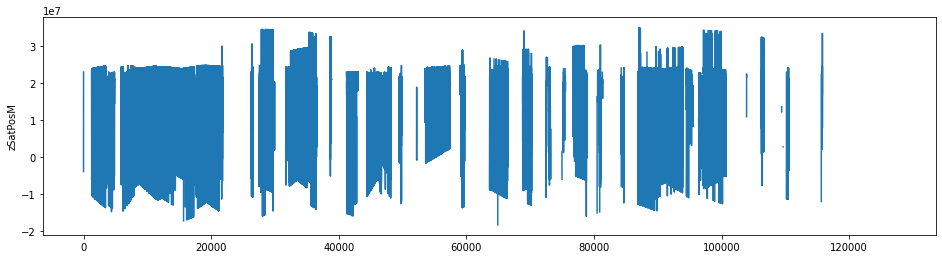

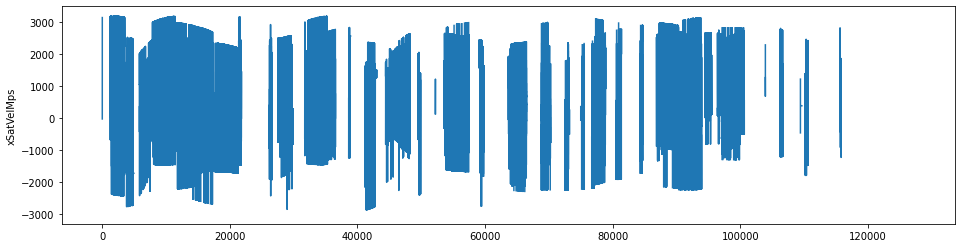

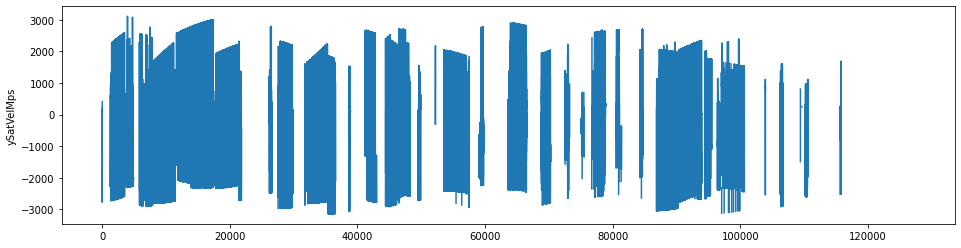

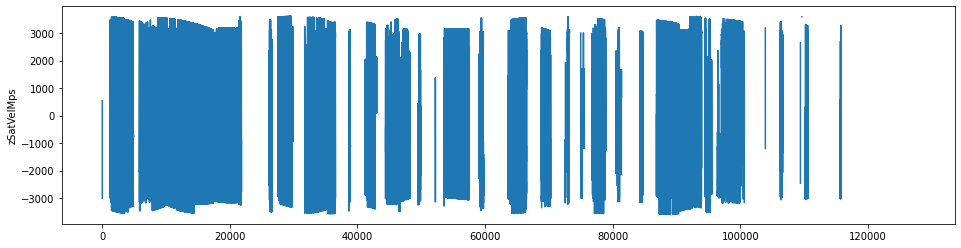

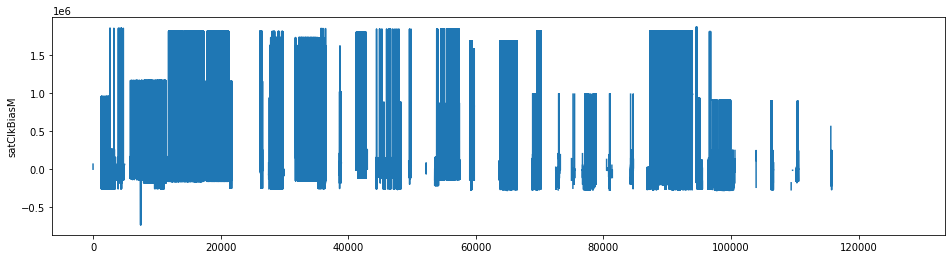

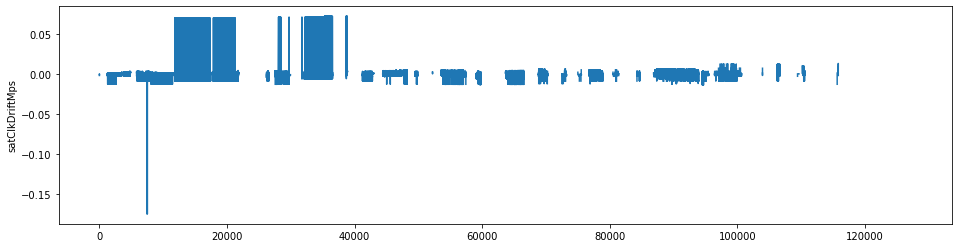

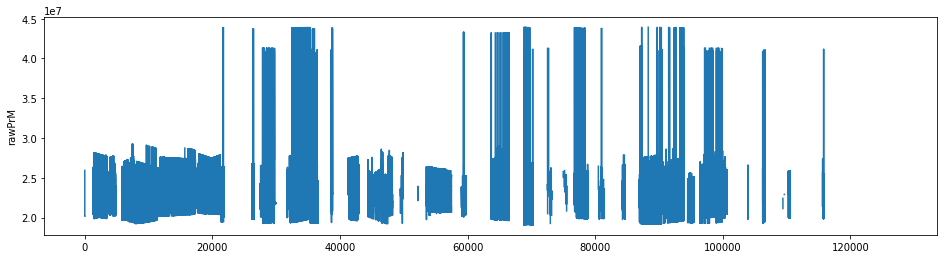

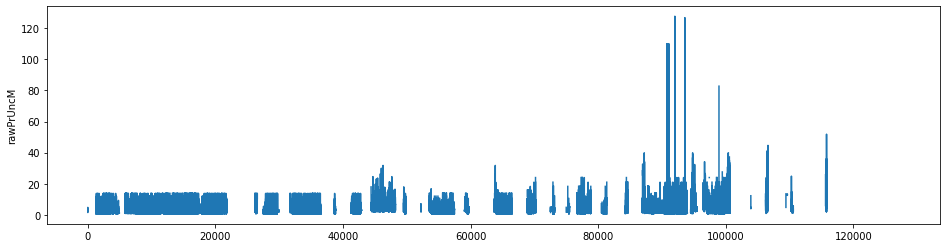

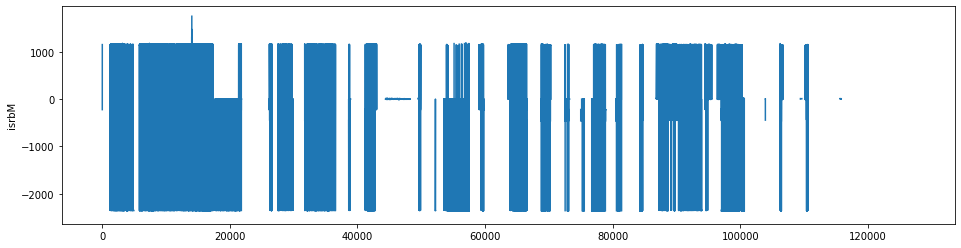

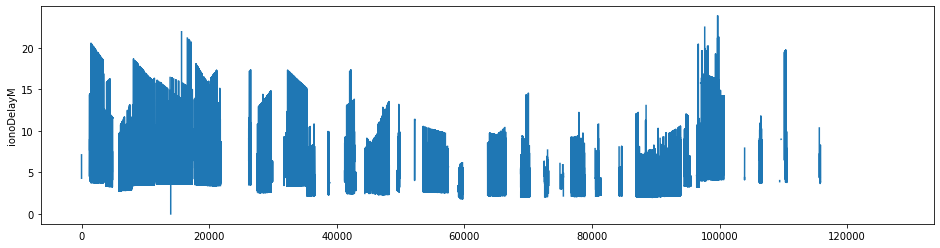

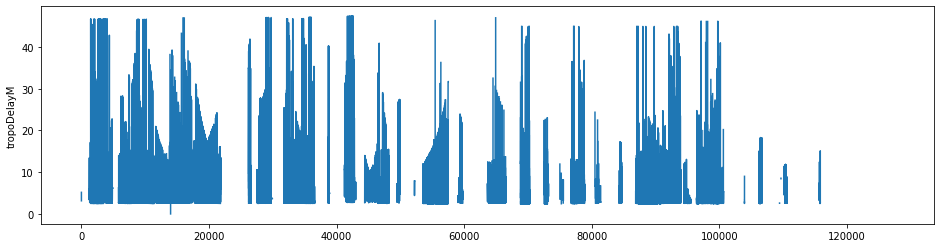

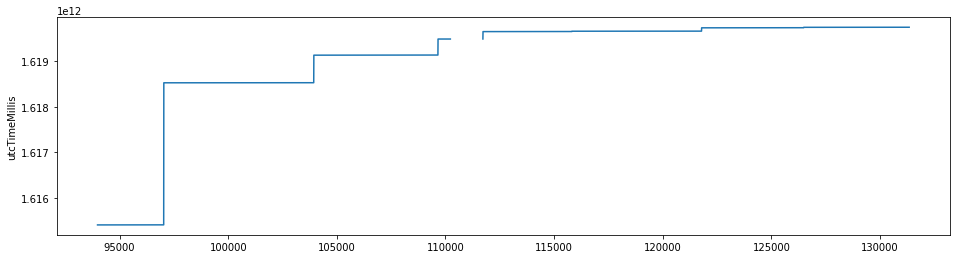

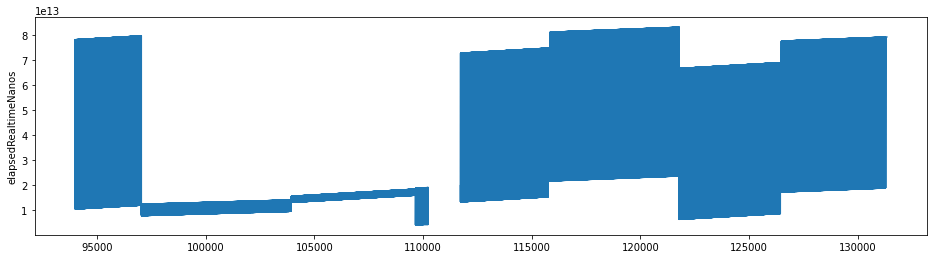

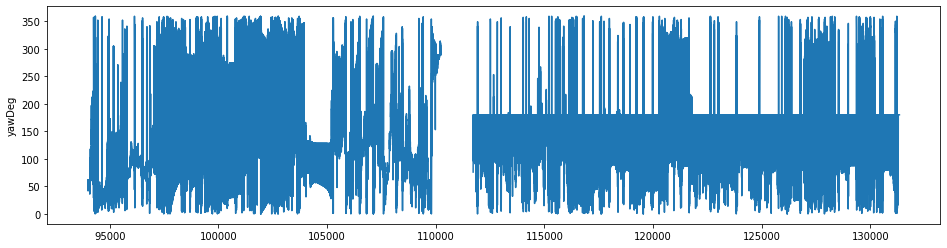

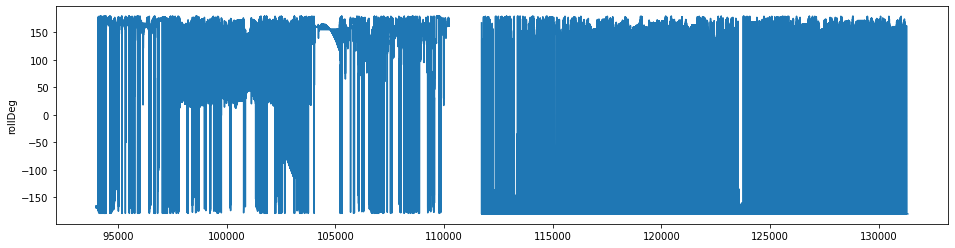

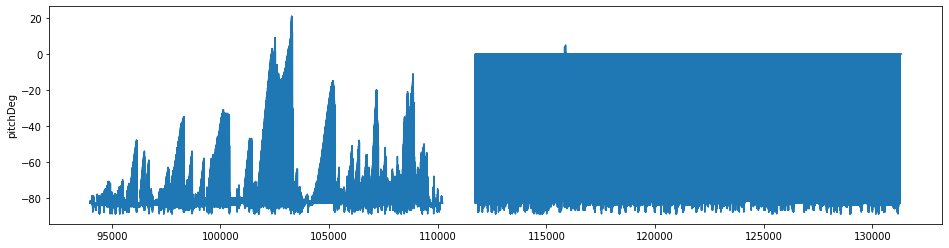

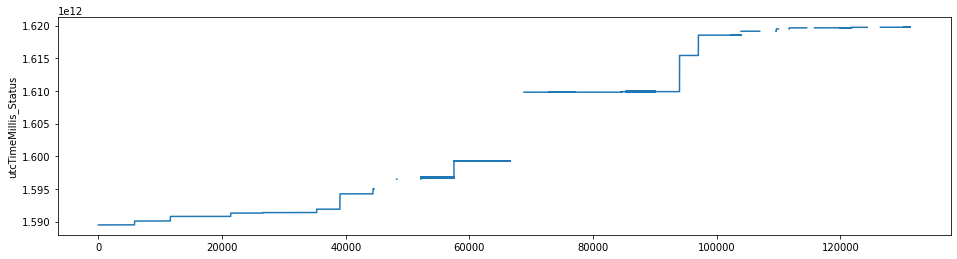

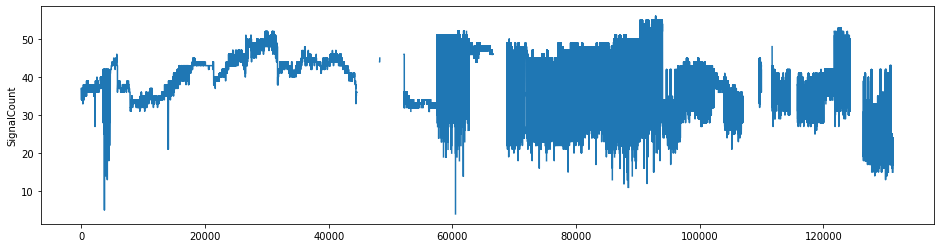

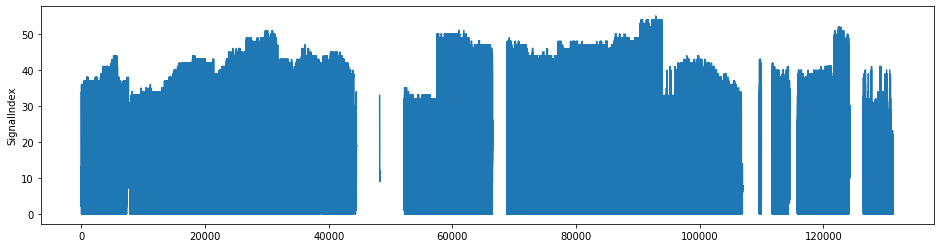

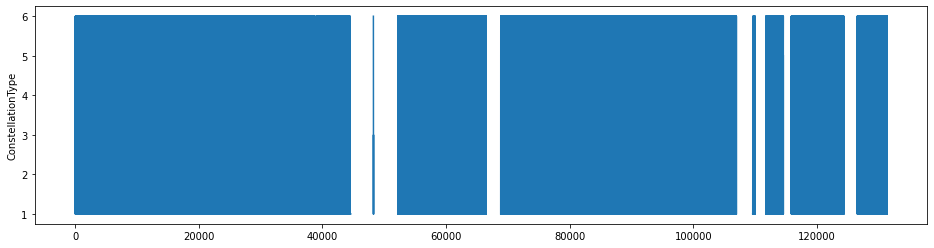

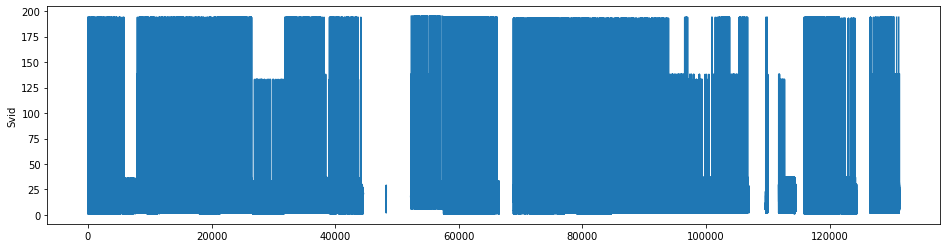

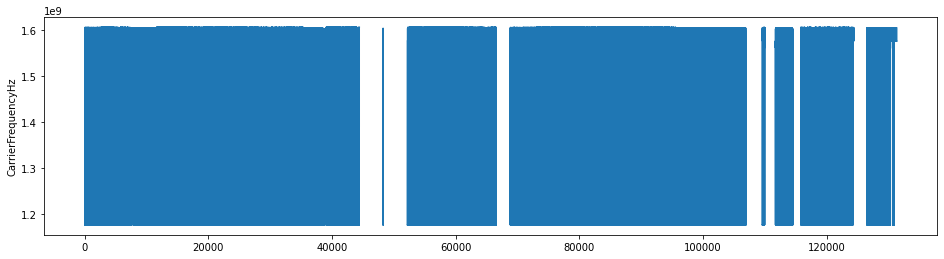

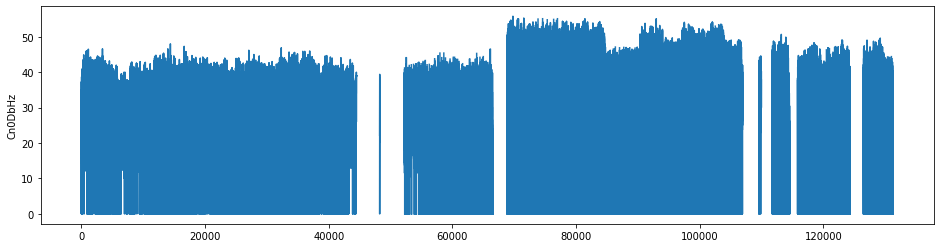

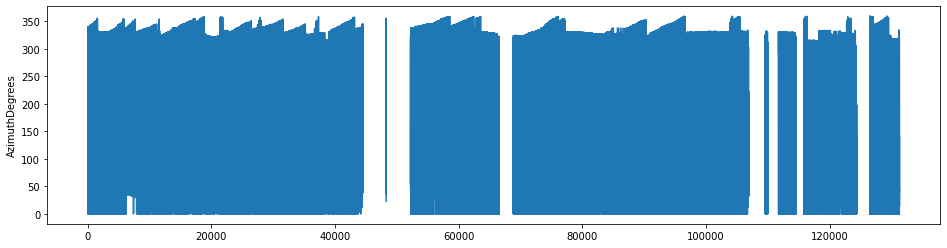

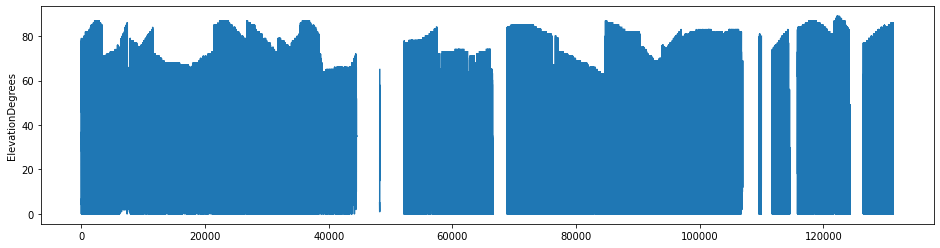

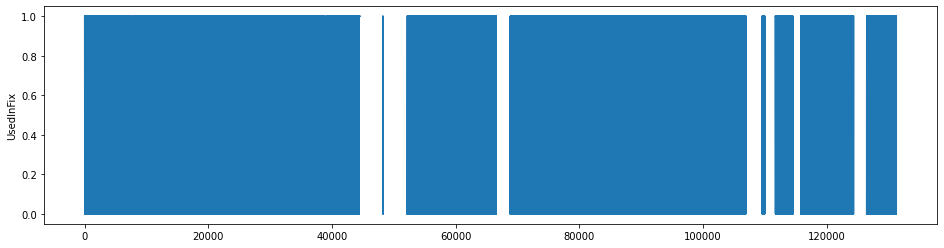

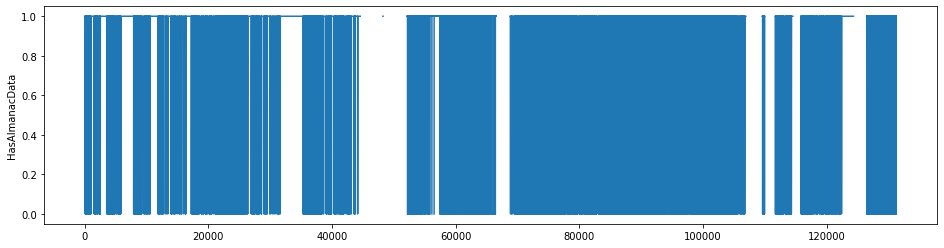

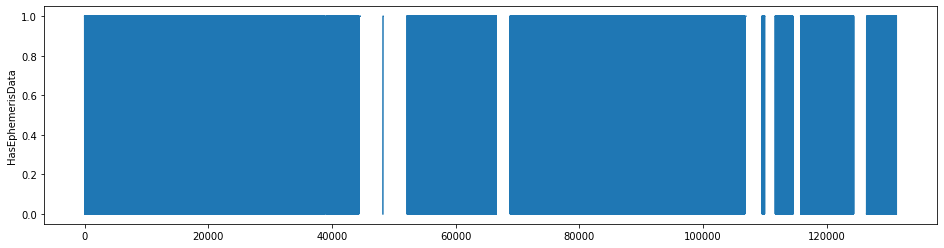

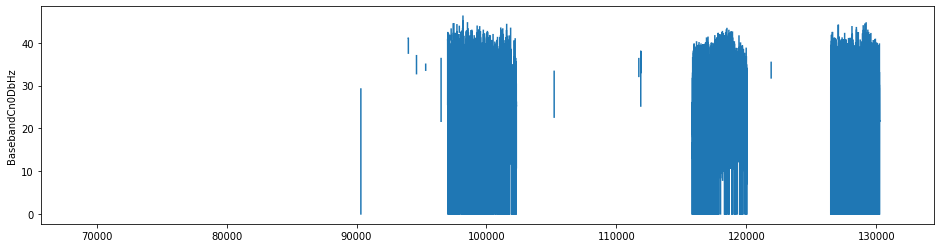

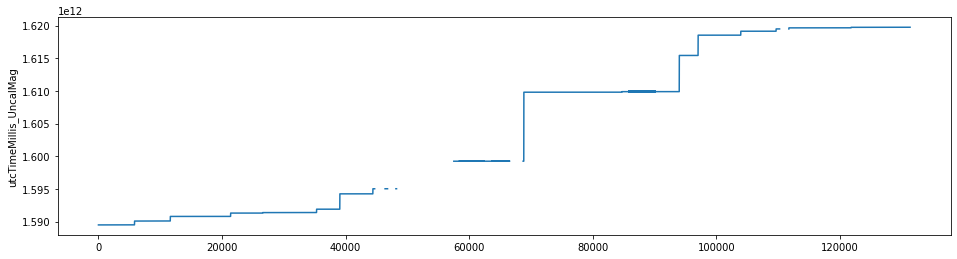

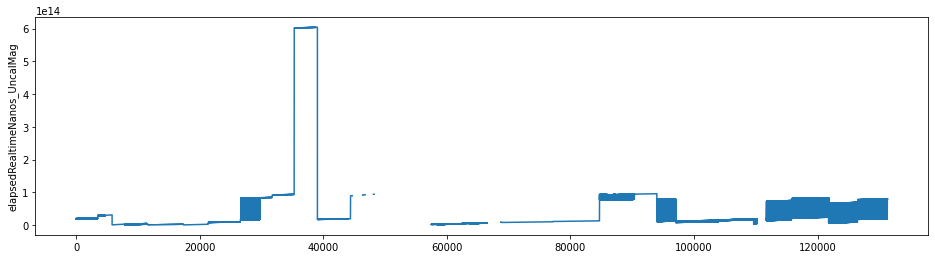

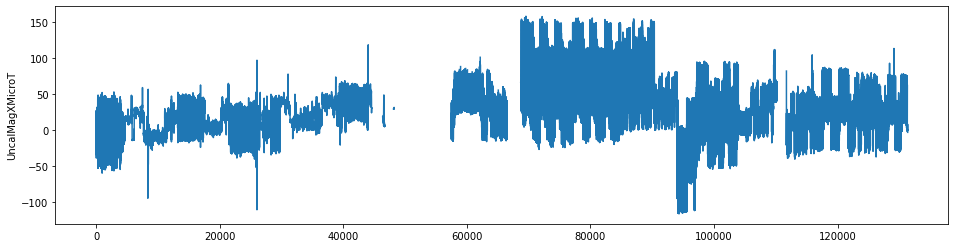

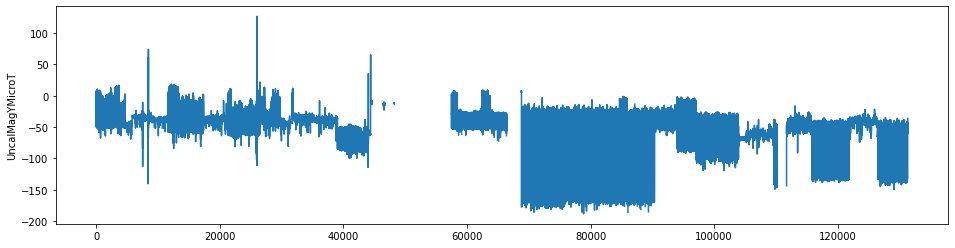

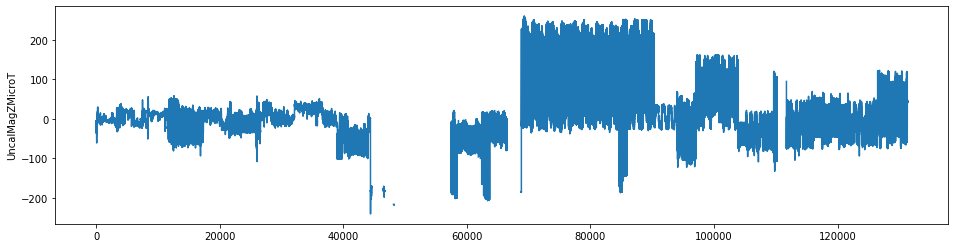

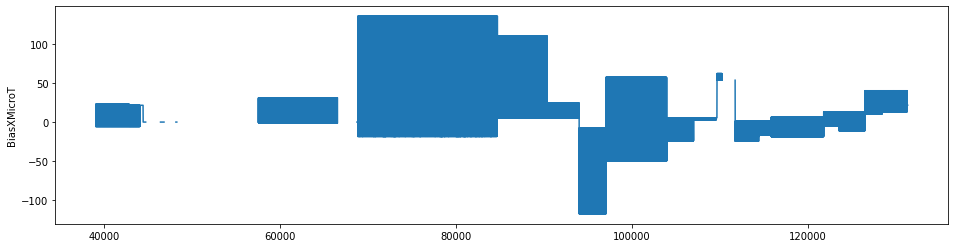

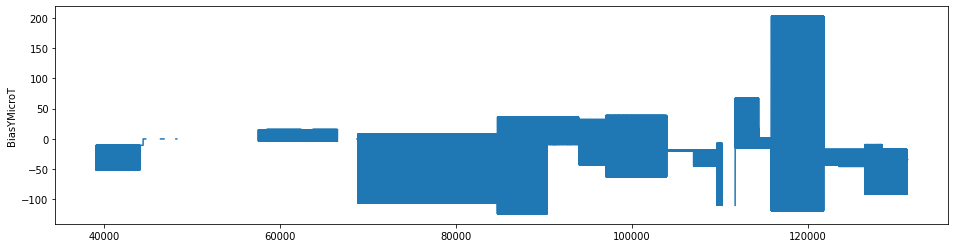

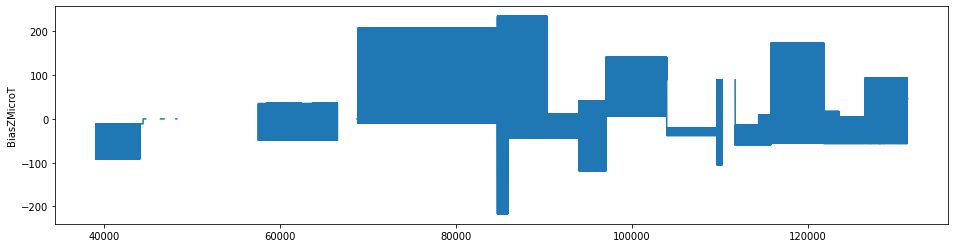

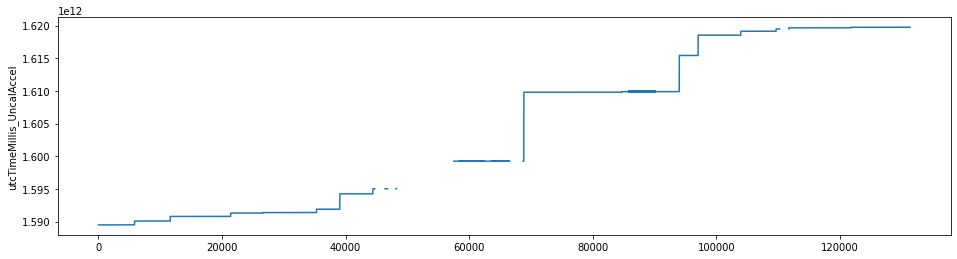

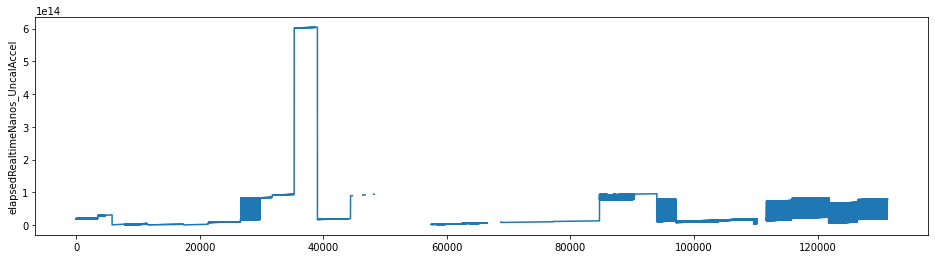

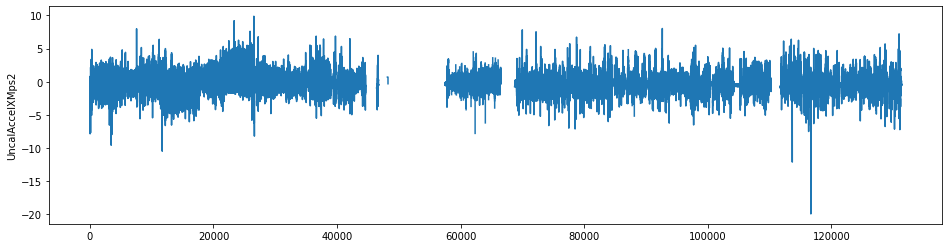

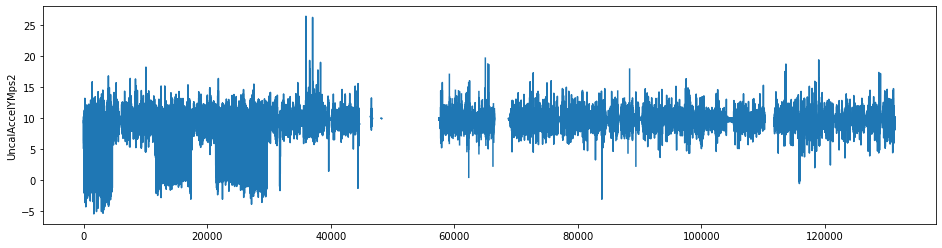

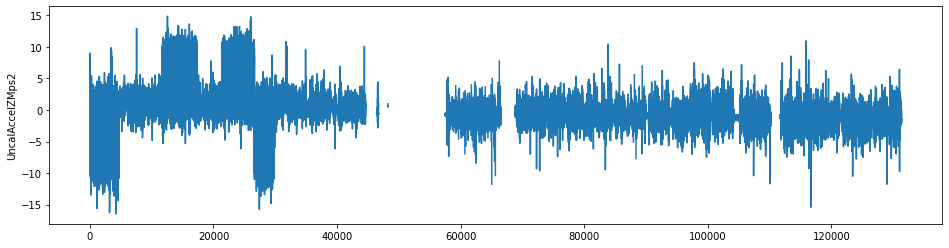

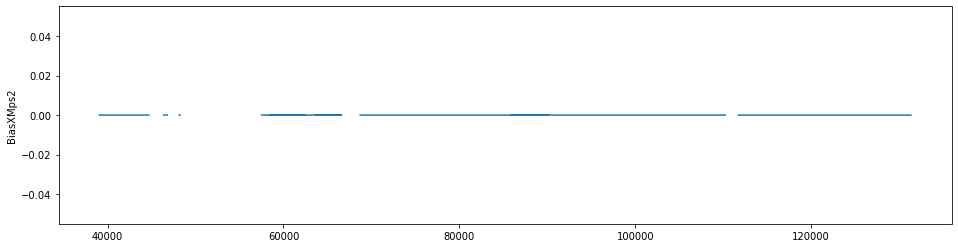

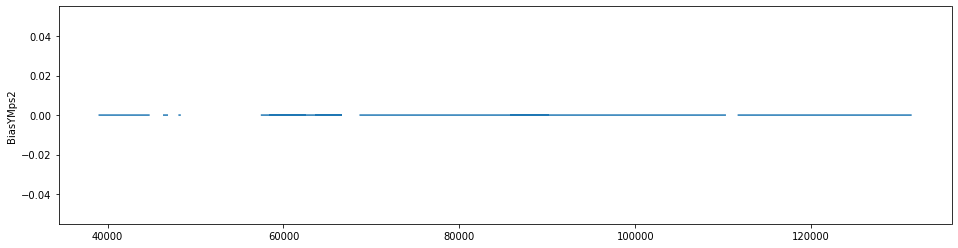

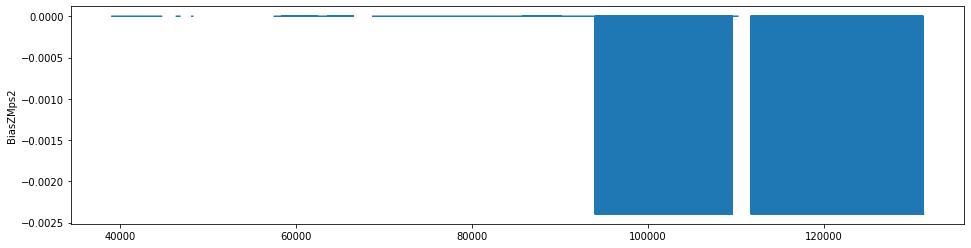

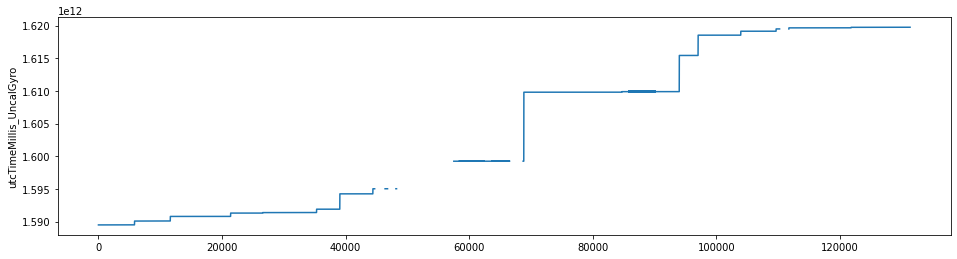

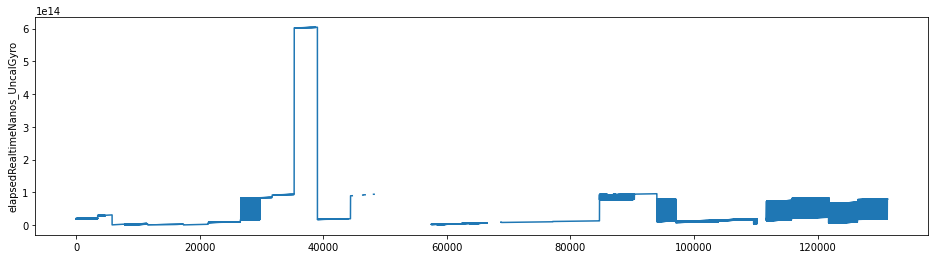

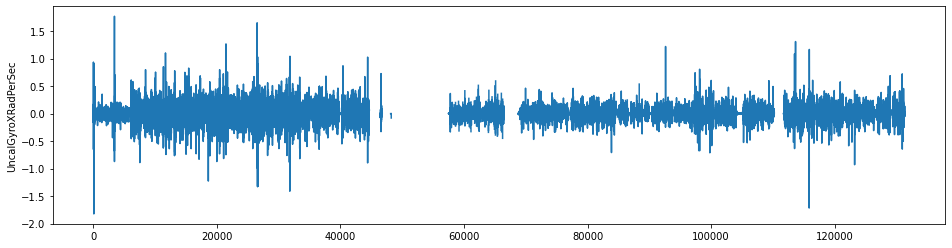

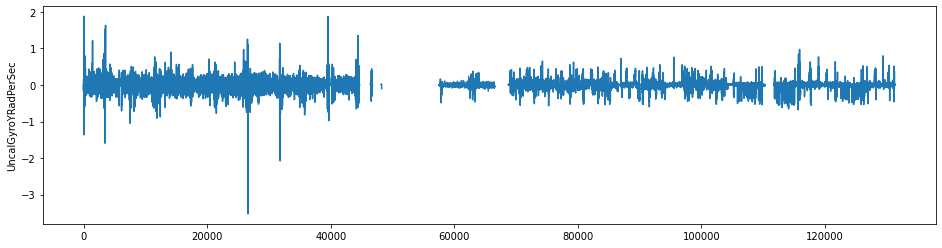

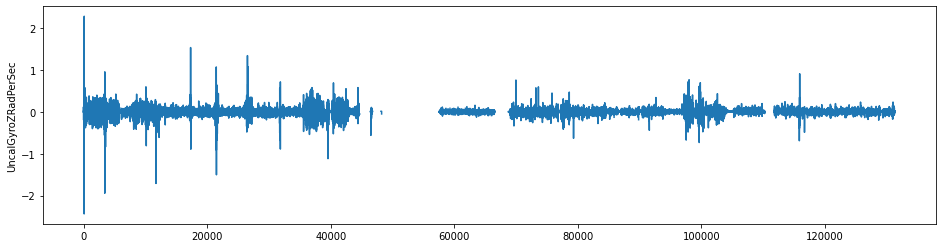

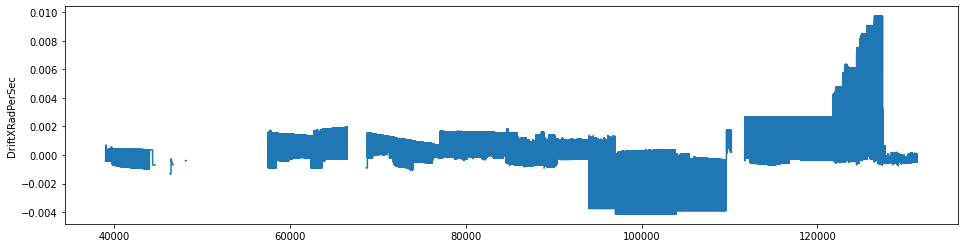

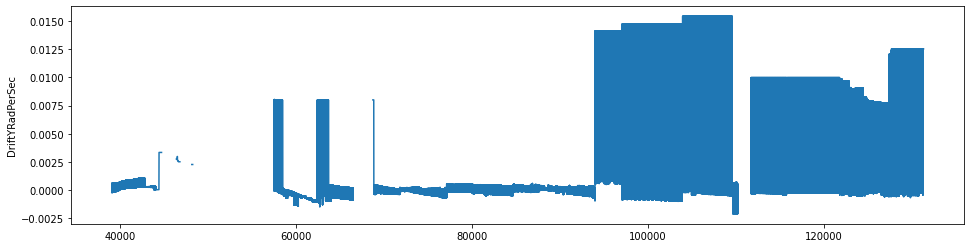

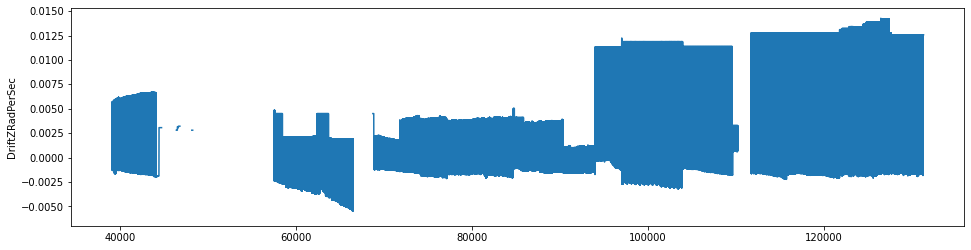

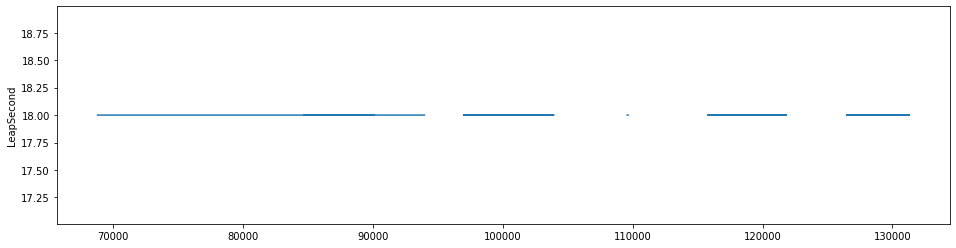

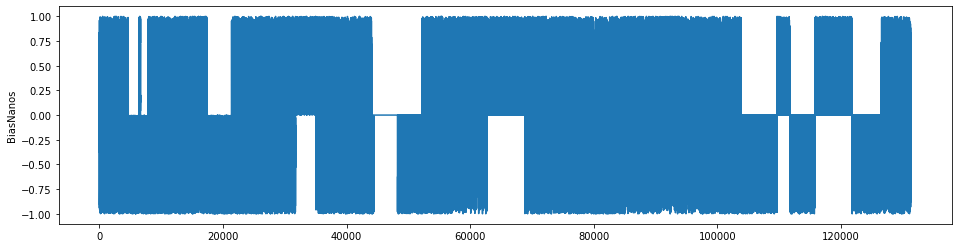

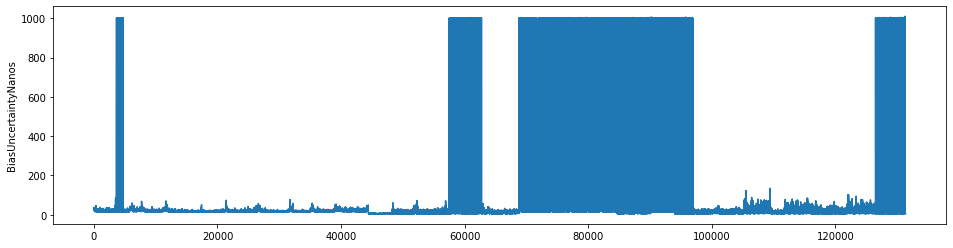

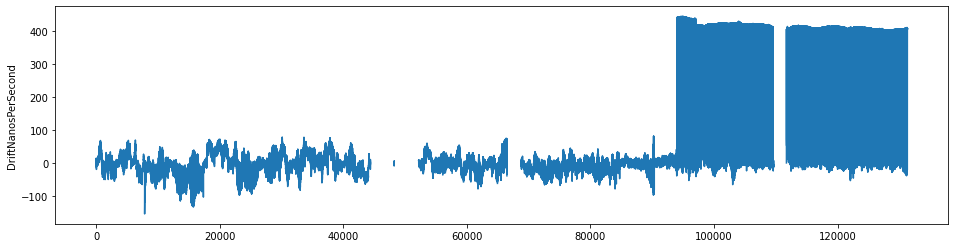

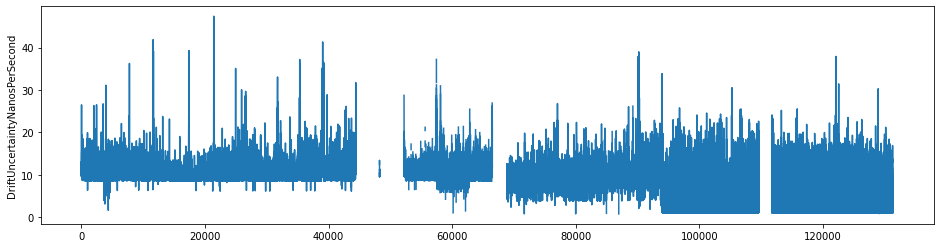

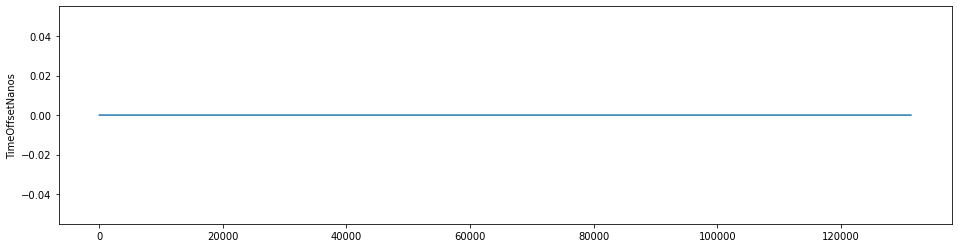

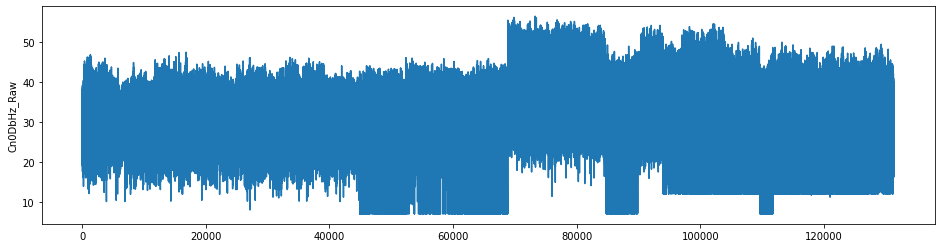

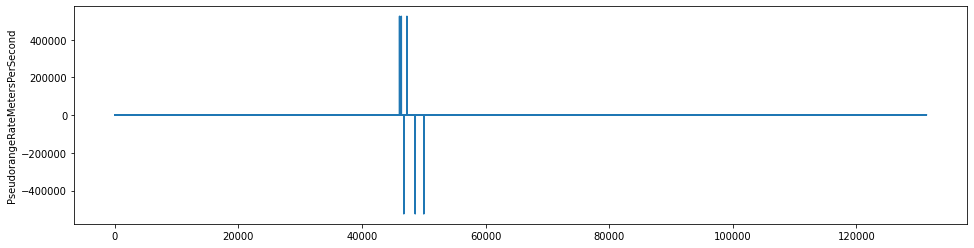

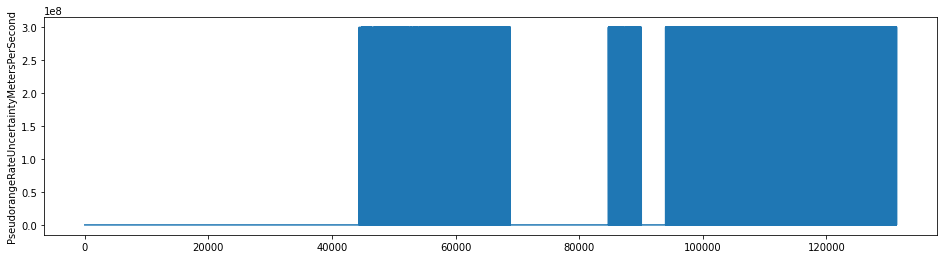

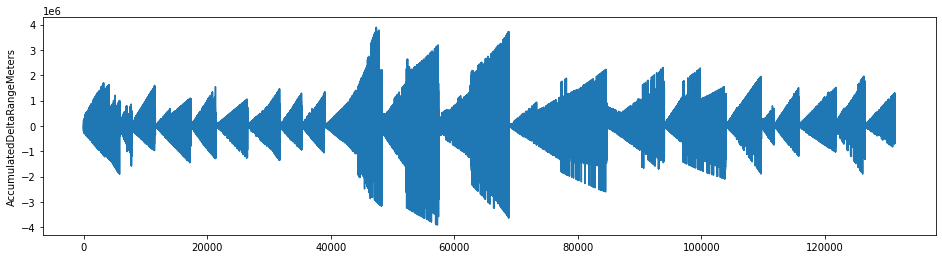

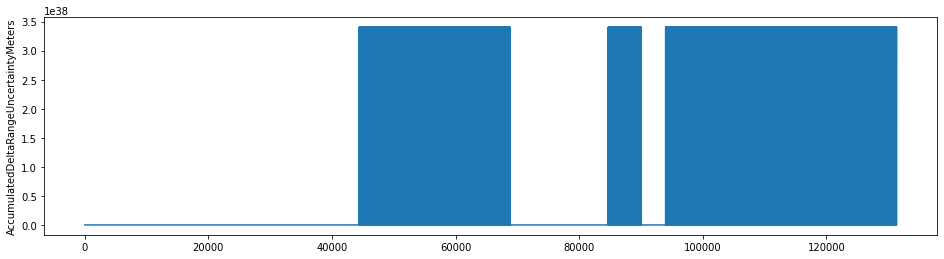

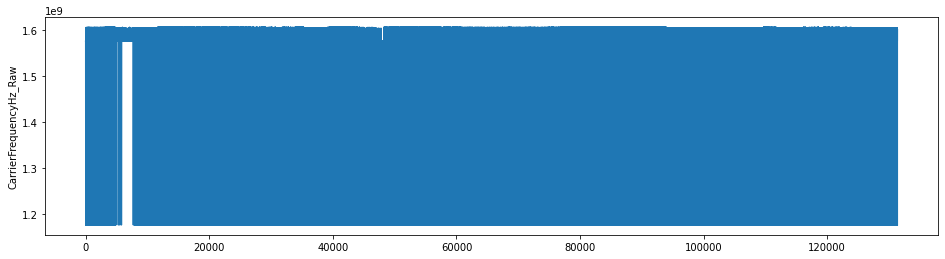

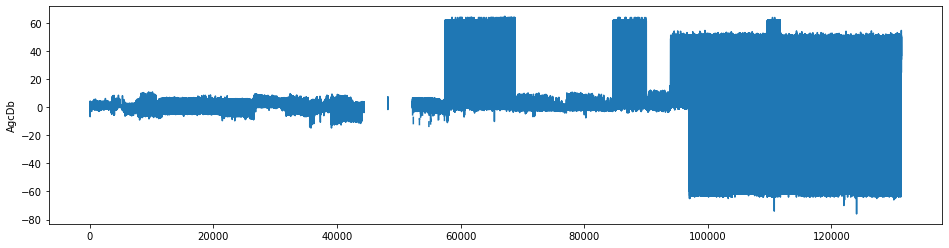

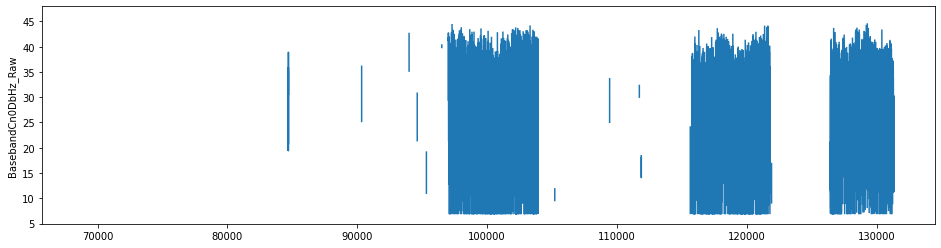

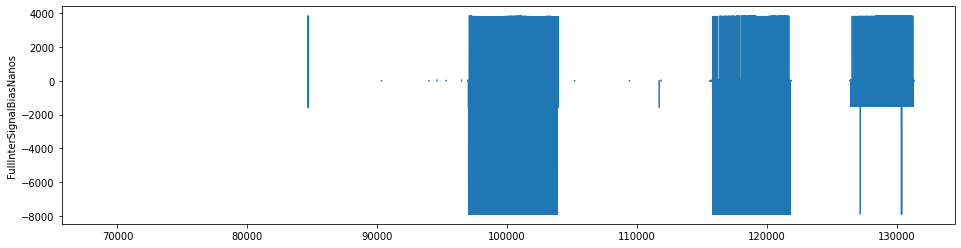

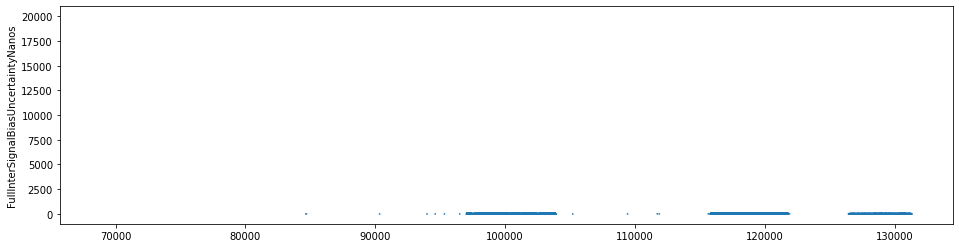

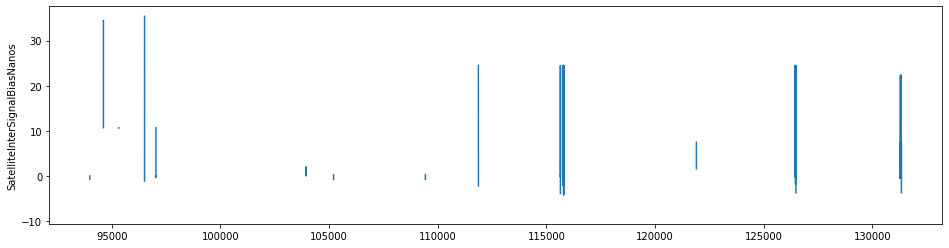

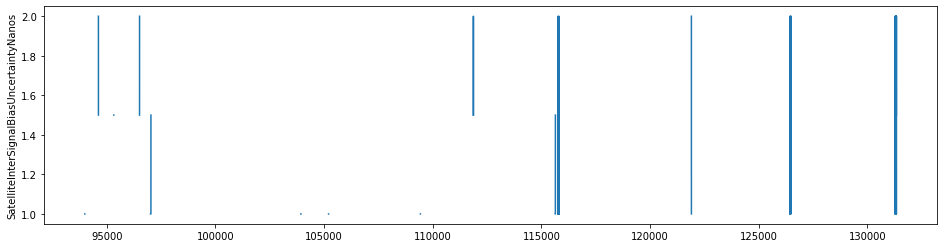

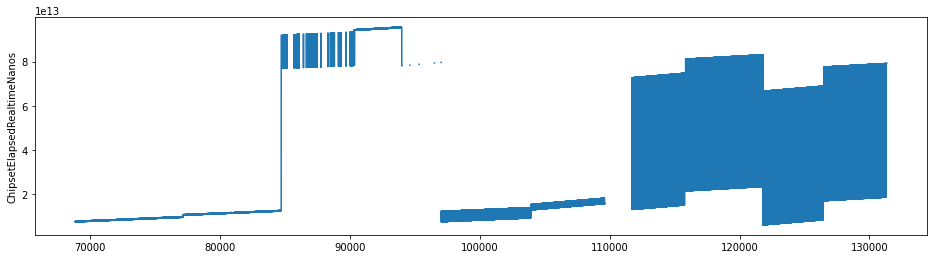

In [8]:
# continuous data
for col in df_train.columns:
    if df_train[col].dtype == float:
        plt.figure(figsize = (16, 4))
        plt.plot(df_train[col])
        plt.ylabel(col)
        

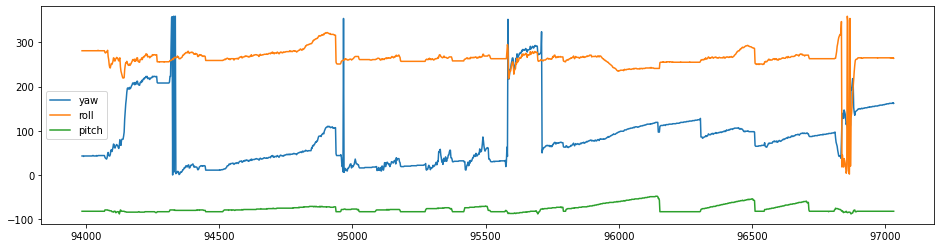

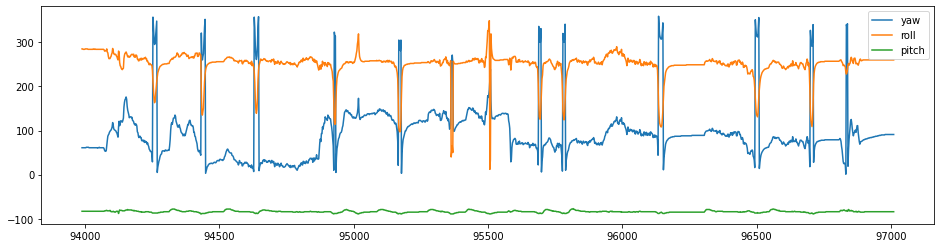

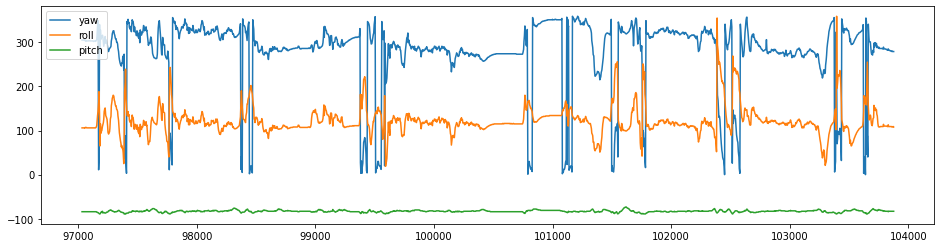

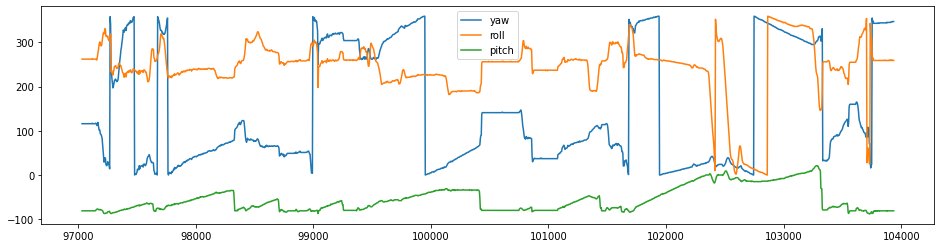

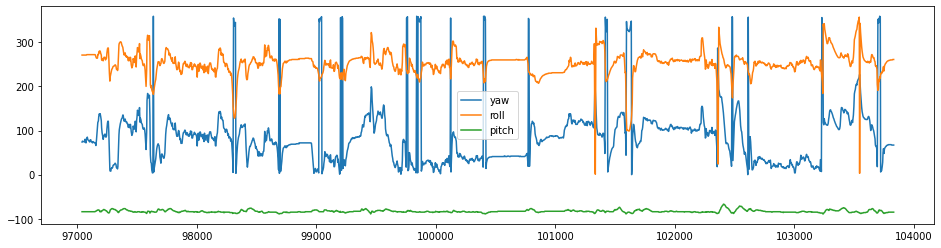

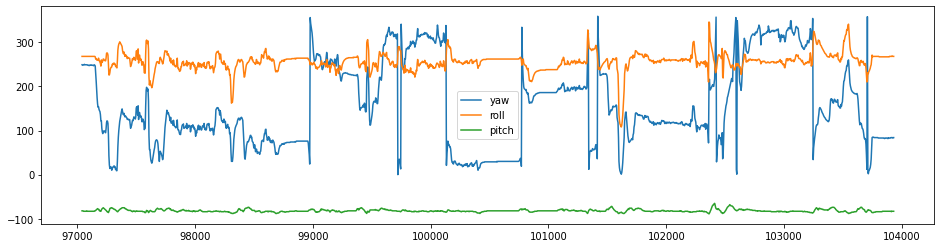

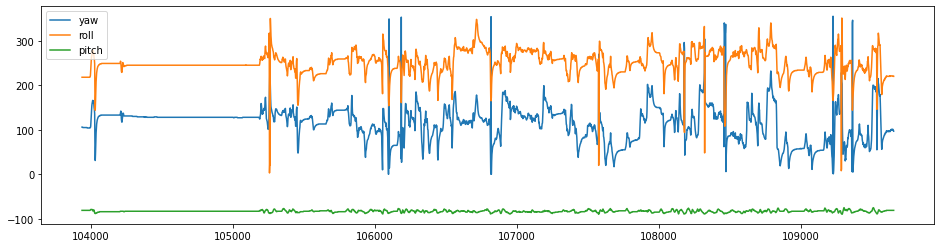

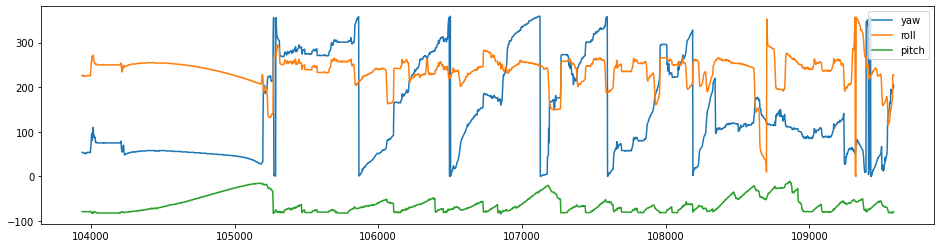

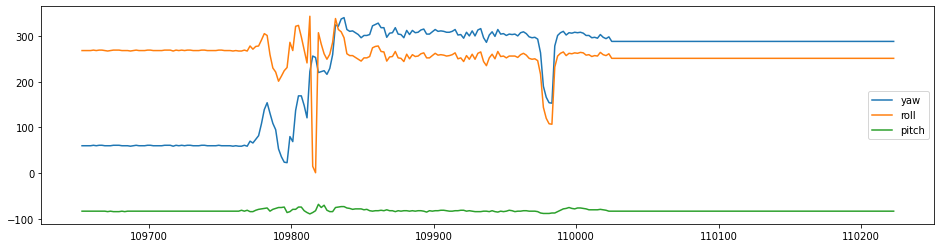

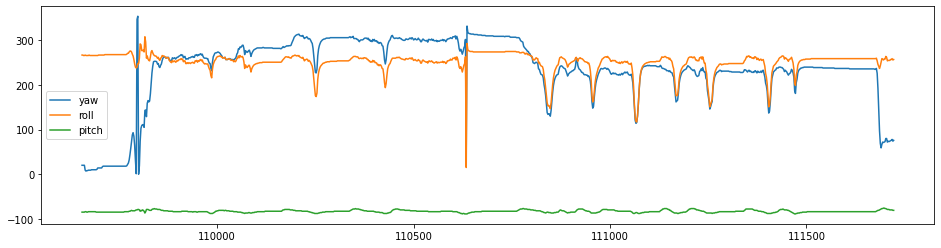

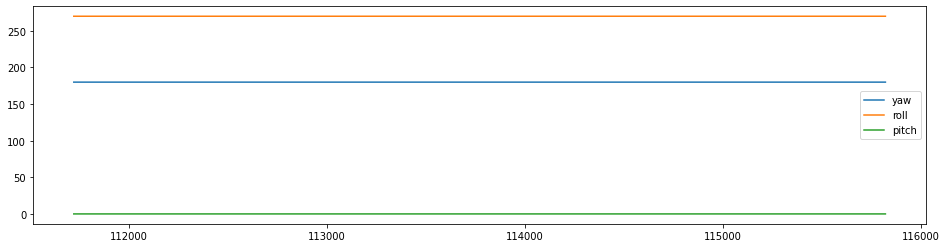

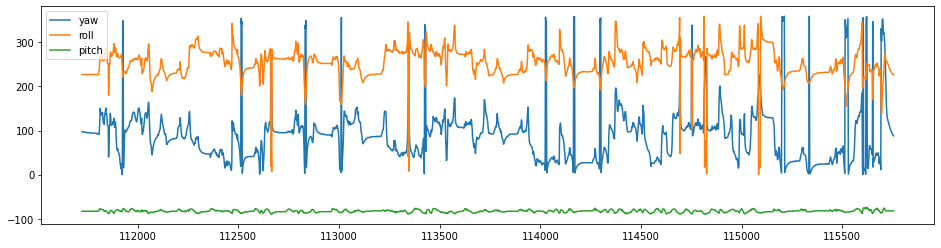

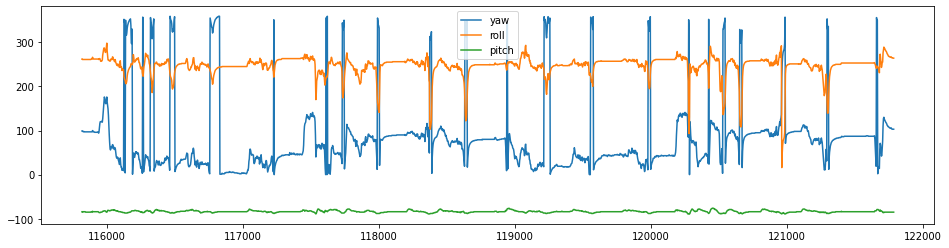

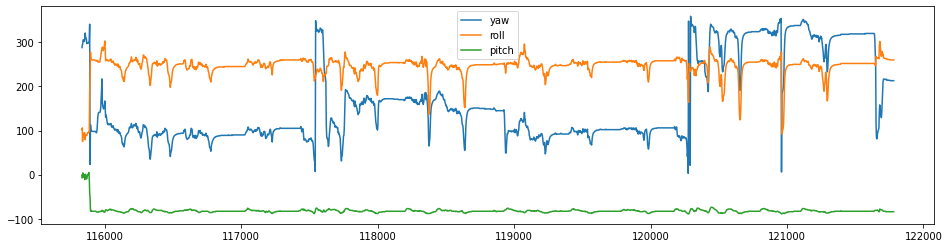

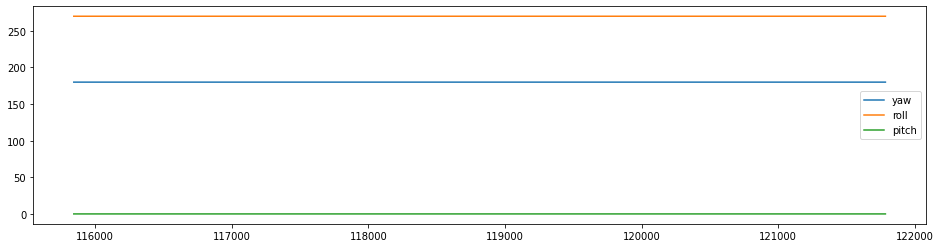

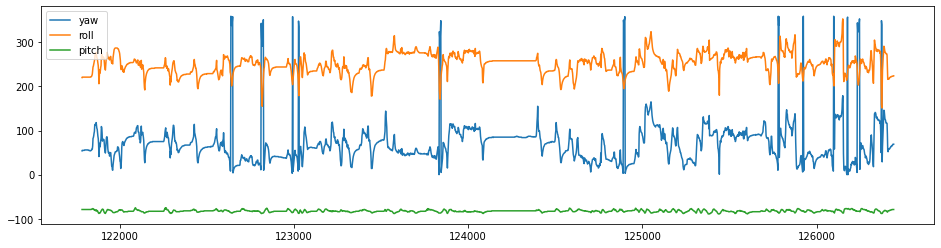

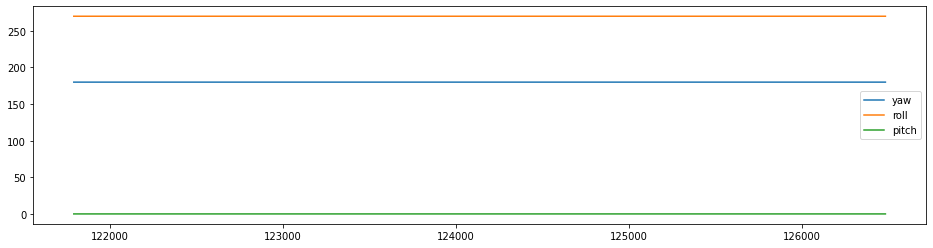

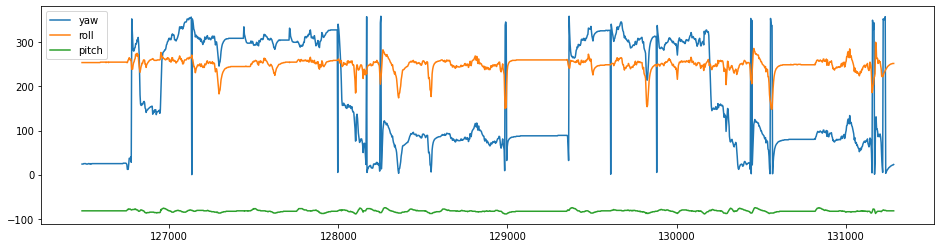

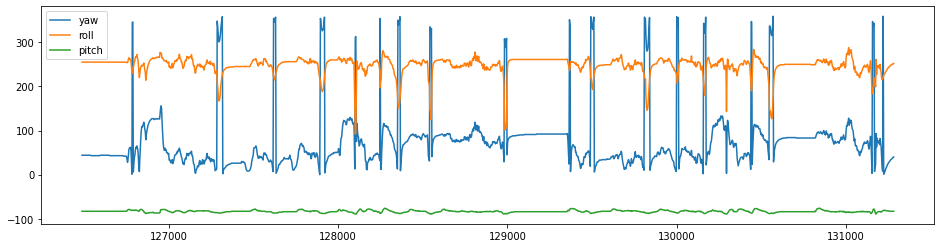

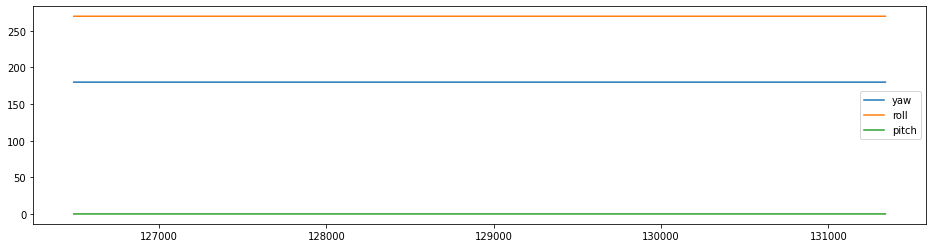

In [9]:
for phone in df_train['phone'].unique():
    temp = df_train[df_train['phone'] == phone]
    if temp['yawDeg'].isna().mean() == 1:
        continue
    plt.figure(figsize = (16,4))
    plt.plot(temp['yawDeg'], label = 'yaw')
    plt.plot((temp['rollDeg']+90)%360, label = 'roll')
    plt.plot(temp['pitchDeg'], label = 'pitch')
    plt.legend()
    
    
    
plt.show()


# Extract Data

## Get dlatDeg, dlngDeg, dheightAboveWgs84EllipsoidM

In [10]:
def getDeltaPositions(df:pd.DataFrame)->pd.DataFrame:
    output = df.copy()
    phones = output['phone'].unique()
    output[['dlatDeg', 'dlngDeg', 'dheight']] = 0
    for phone in phones:
        latDeg = output.loc[output['phone'] == phone, 'latDeg']
        output.loc[output['phone'] == phone, 'dlatDeg'] = latDeg - latDeg.iloc[0]
        
        lngDeg = output.loc[output['phone'] == phone, 'lngDeg']
        output.loc[output['phone'] == phone, 'dlngDeg'] = lngDeg - lngDeg.iloc[0]
        
        heightAboveWgs84EllipsoidM = output.loc[output['phone'] == phone, 'heightAboveWgs84EllipsoidM']
        output.loc[output['phone'] == phone, 'dheight'] = heightAboveWgs84EllipsoidM - heightAboveWgs84EllipsoidM.iloc[0]
        
    return output

In [11]:
df_train = getDeltaPositions(df_train)
df_test = getDeltaPositions(df_test)

## Scaler

In [12]:
class Scaler():
    def __init__(self, target_columns):
        self.target_columns = target_columns
        self.renames_columns = [name + "_Scaled" for name in target_columns]
        self.scaler = dict()
        for name in target_columns:
            self.scaler[name] = StandardScaler()
            
    def fit(self, df:pd.DataFrame):
        for col in self.target_columns:
            self.scaler[col].fit(df[col].values.reshape(-1, 1))
            
    def transform(self, df:pd.DataFrame):
        output = df.copy()
        for col,recol in zip(self.target_columns, self.renames_columns):
            output[recol] = self.scaler[col].transform(df[col].values.reshape(-1, 1))
            output[recol].fillna(0, inplace = True)
        return output
        
    

In [13]:
target_columns = ['dlatDeg', 'dlngDeg', 'dheight',
                 'xSatPosM', 'ySatPosM', 'zSatPosM', 'xSatVelMps', 'ySatVelMps', 'zSatVelMps',
                  'UncalGyroXRadPerSec', 'UncalGyroYRadPerSec', 'UncalGyroZRadPerSec', 
                  'DriftXRadPerSec', 'DriftYRadPerSec', 'DriftZRadPerSec', 
                  'UncalAccelXMps2', 'UncalAccelYMps2', 'UncalAccelZMps2', 'BiasXMps2', 'BiasYMps2', 'BiasZMps2',
                  'UncalMagXMicroT', 'UncalMagYMicroT', 'UncalMagZMicroT', 'BiasXMicroT', 'BiasYMicroT', 'BiasZMicroT',
                  'yawDeg', 'rollDeg', 'pitchDeg'
                 ]

In [14]:
scaler = Scaler(target_columns)
scaler.fit(df_train)

df_train = scaler.transform(df_train)
df_test = scaler.transform(df_test)

In [15]:
df_train[scaler.renames_columns].describe()

,dlatDeg_Scaled,dlngDeg_Scaled,dheight_Scaled,xSatPosM_Scaled,ySatPosM_Scaled,zSatPosM_Scaled,xSatVelMps_Scaled,ySatVelMps_Scaled,zSatVelMps_Scaled,UncalGyroXRadPerSec_Scaled,...,BiasZMps2_Scaled,UncalMagXMicroT_Scaled,UncalMagYMicroT_Scaled,UncalMagZMicroT_Scaled,BiasXMicroT_Scaled,BiasYMicroT_Scaled,BiasZMicroT_Scaled,yawDeg_Scaled,rollDeg_Scaled,pitchDeg_Scaled
count,1.313420e+05,1.313420e+05,1.313420e+05,1.313420e+05,1.313420e+05,1.313420e+05,1.313420e+05,1.313420e+05,1.313420e+05,1.313420e+05,...,1.313420e+05,1.313420e+05,1.313420e+05,1.313420e+05,1.313420e+05,1.313420e+05,1.313420e+05,1.313420e+05,1.313420e+05,1.313420e+05
mean,5.390932e-17,-7.898406e-18,5.193472e-17,5.626262e-17,1.646763e-16,4.436091e-17,7.682011e-17,-1.990831e-17,5.193472e-18,7.326988e-18,...,-9.348250e-17,4.674125e-17,-8.742345e-17,1.612140e-17,-2.932148e-17,2.813131e-18,-2.250505e-17,-3.245920e-19,-5.842656e-18,-4.133138e-17
std,1.000004e+00,1.000004e+00,1.000004e+00,7.262166e-01,7.262166e-01,7.262166e-01,7.262166e-01,7.262166e-01,7.262166e-01,9.309703e-01,...,7.545529e-01,9.309703e-01,9.309703e-01,9.309703e-01,7.545529e-01,7.545529e-01,7.545529e-01,5.279368e-01,5.279368e-01,5.279368e-01
min,-3.367212e+00,-2.837517e+00,-8.485201e+01,-1.703958e+00,-1.604379e+00,-2.959637e+00,-2.805447e+00,-2.017447e+00,-1.572678e+00,-2.136508e+01,...,-2.065101e+00,-3.679357e+00,-3.661872e+00,-3.605178e+00,-3.147636e+00,-1.970971e+00,-2.882745e+00,-1.574187e+00,-1.460859e+00,-7.973284e-01
25%,-1.426406e-01,-2.570525e-01,-3.623789e-01,-3.396268e-01,-2.148332e-01,0.000000e+00,-1.517319e-01,-2.671640e-02,-1.265310e-01,-2.222134e-01,...,0.000000e+00,-4.799674e-01,-6.136577e-02,-3.377524e-01,-2.464427e-01,0.000000e+00,-3.070616e-01,0.000000e+00,0.000000e+00,0.000000e+00
50%,6.784625e-02,8.844239e-02,-2.357607e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,1.474031e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,1.870814e-01,2.033670e-01,2.792265e-01,0.000000e+00,0.000000e+00,4.262861e-01,0.000000e+00,9.489771e-02,8.910870e-02,2.230717e-01,...,4.842377e-01,4.069022e-01,4.323310e-01,1.889190e-01,8.084452e-02,1.905548e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,2.689582e+00,2.871625e+00,1.882394e+02,2.588478e+00,3.452574e+00,2.112431e+00,2.136355e+00,2.648124e+00,1.642510e+00,2.070062e+01,...,4.842377e-01,3.247420e+00,4.816066e+00,3.776263e+00,2.811007e+00,3.914536e+00,2.719237e+00,2.416793e+00,8.844088e-01,2.379817e+00


## Categorical Variables
### signalType

In [16]:
categories_signal_type = ['GPS_L1', 'GPS_L5', 'GAL_E1', 'GAL_E5A', 'GLO_G1', 'BDS_B1I', 'BDS_B1C', 'BDS_B2A', 'QZS_J1', 'QZS_J5']


In [17]:
df_train['signalType'].value_counts()

GPS_L1     22172
GLO_G1     13229
GAL_E1     12903
GAL_E5A     8484
GPS_L5      7146
BDS_B1I     4923
QZS_J1       215
QZS_J5       196
Name: signalType, dtype: int64

In [18]:
df_test['signalType'].value_counts()

GPS_L1     16620
GAL_E1     11670
GLO_G1     11008
GAL_E5A     6913
GPS_L5      4650
BDS_B1I     4390
QZS_J1       143
QZS_J5       110
Name: signalType, dtype: int64

In [19]:
def GetSignalTypeDummies(df:pd.DataFrame, cols = ['GPS_L1', 'GPS_L5', 'GAL_E1', 'GAL_E5A', 'GLO_G1', 'BDS_B1I', 'BDS_B1C', 'BDS_B2A', 'QZS_J1', 'QZS_J5']):
    output = df.copy()
    for col in cols:
        output[col] = (df['signalType'] == col).astype(int)
    return output    

In [20]:
df_train = GetSignalTypeDummies(df_train)
df_test = GetSignalTypeDummies(df_test)

In [21]:
print(df_train.shape)
print(df_test.shape)

(131342, 148)
(91486, 140)


In [26]:
df_train.fillna(0, inplace = True)
df_test.fillna(0, inplace = True)

#  Output

In [27]:
df_train.to_pickle(str(data_dir / "gsdc_extract_train.pkl.gzip"))
df_test.to_pickle(str(data_dir / "gsdc_extract_test.pkl.gzip"))

In [28]:
df_train.info(verbose = True, null_counts = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131342 entries, 0 to 131341
Data columns (total 148 columns):
 #   Column                                     Non-Null Count   Dtype  
---  ------                                     --------------   -----  
 0   collectionName                             131342 non-null  object 
 1   phoneName                                  131342 non-null  object 
 2   millisSinceGpsEpoch                        131342 non-null  int64  
 3   latDeg                                     131342 non-null  float64
 4   lngDeg                                     131342 non-null  float64
 5   heightAboveWgs84EllipsoidM                 131342 non-null  float64
 6   phone                                      131342 non-null  object 
 7   timeSinceFirstFixSeconds                   131342 non-null  float64
 8   hDop                                       131342 non-null  float64
 9   vDop                                       131342 non-null  float64
 10  speedMp